In [1]:
import torch
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import joblib


# 1. 初始化模型和预处理步骤

In [3]:
# 设置设备
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"使用设备: {device}")

# 初始化ResNet18
weights = models.ResNet18_Weights.IMAGENET1K_V1
model = models.resnet18(weights=weights).to(device)
model = torch.nn.Sequential(*list(model.children())[:-1])  # 移除分类层
model.eval()

# 图像预处理
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


使用设备: mps


# 2. 特征提取函数

In [4]:
def extract_features_batch(image_paths, batch_size=32):
    """从图像中批量提取特征"""
    features_list = []
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i + batch_size]
        batch_images = []
        for p in batch_paths:
            try:
                img = Image.open(p).convert("RGB")
                batch_images.append(preprocess(img))
            except Exception as e:
                print(f"处理图像 {p} 时出错: {e}")
                # 添加一个零张量作为替代
                batch_images.append(torch.zeros(3, 224, 224))
        
        batch_tensor = torch.stack(batch_images).to(device)
        with torch.no_grad():
            batch_features = model(batch_tensor)
            batch_features = batch_features.squeeze(-1).squeeze(-1)
        features_list.append(batch_features.cpu().numpy())
        print(f"已处理 {i+len(batch_paths)}/{len(image_paths)} 张图像")
    
    return np.vstack(features_list)

# 3. 数据加载和准备

In [16]:

def load_data(data_path, image_dir):
    """加载和准备数据"""
    df = pd.read_csv(data_path, sep='\t')
    
    # 展示数据集分布
    print(f"数据集大小: {len(df)}")
    print(f"标签分布:\n{df['label'].value_counts()}")
    
    # 确保CNV特征是数值型
    for col in ['cn_2', 'cn_3', 'cn_segments']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        # 填充缺失值
        df[col].fillna(df[col].median(), inplace=True)
    
    # 构建完整图像路径
    image_paths = [os.path.join(image_dir, img) for img in df['image_path']]
    
    # 检查图像是否存在
    valid_paths = []
    valid_indices = []
    for i, path in enumerate(image_paths):
        if os.path.exists(path):
            valid_paths.append(path)
            valid_indices.append(i)
        else:
            print(f"警告: 图像 {path} 不存在")
    
    # 筛选有效数据
    df_valid = df.iloc[valid_indices].reset_index(drop=True)
    features = df_valid[['cn_2', 'cn_3', 'cn_segments']].values
    labels = df_valid['label'].values
    
    return df_valid, valid_paths, features, labels

# 加载训练数据
print("加载训练数据...")
train_df, train_image_paths, train_cnv_features, train_labels = load_data(
    '/Volumes/T7-shield/CS-Bachelor-Thesis/CNN_model/model_data/train_data.tsv',
    '/Volumes/T7-shield/CS-Bachelor-Thesis/CNN_model/model_data/train'
)

# 加载测试数据
print("加载测试数据...")
test_df, test_image_paths, test_cnv_features, test_labels = load_data(
    '/Volumes/T7-shield/CS-Bachelor-Thesis/CNN_model/model_data/test_data.tsv',
    '/Volumes/T7-shield/CS-Bachelor-Thesis/CNN_model/model_data/test'
)


加载训练数据...
数据集大小: 2564
标签分布:
label
1    1775
0     789
Name: count, dtype: int64
加载测试数据...
数据集大小: 284
标签分布:
label
1    212
0     72
Name: count, dtype: int64


# 4. 特征提取

In [7]:
# 提取训练图像特征
print("提取训练图像特征...")
train_image_features = extract_features_batch(train_image_paths)
print(f"训练图像特征形状: {train_image_features.shape}")

# 提取测试图像特征
print("提取测试图像特征...")
test_image_features = extract_features_batch(test_image_paths)
print(f"测试图像特征形状: {test_image_features.shape}")

提取训练图像特征...
已处理 32/2564 张图像
已处理 64/2564 张图像
已处理 96/2564 张图像
已处理 128/2564 张图像
已处理 160/2564 张图像
已处理 192/2564 张图像
已处理 224/2564 张图像
已处理 256/2564 张图像
已处理 288/2564 张图像
已处理 320/2564 张图像
已处理 352/2564 张图像
已处理 384/2564 张图像
已处理 416/2564 张图像
已处理 448/2564 张图像
已处理 480/2564 张图像
已处理 512/2564 张图像
已处理 544/2564 张图像
已处理 576/2564 张图像
已处理 608/2564 张图像
已处理 640/2564 张图像
已处理 672/2564 张图像
已处理 704/2564 张图像
已处理 736/2564 张图像
已处理 768/2564 张图像
已处理 800/2564 张图像
已处理 832/2564 张图像
已处理 864/2564 张图像
已处理 896/2564 张图像
已处理 928/2564 张图像
已处理 960/2564 张图像
已处理 992/2564 张图像
已处理 1024/2564 张图像
已处理 1056/2564 张图像
已处理 1088/2564 张图像
已处理 1120/2564 张图像
已处理 1152/2564 张图像
已处理 1184/2564 张图像
已处理 1216/2564 张图像
已处理 1248/2564 张图像
已处理 1280/2564 张图像
已处理 1312/2564 张图像
已处理 1344/2564 张图像
已处理 1376/2564 张图像
已处理 1408/2564 张图像
已处理 1440/2564 张图像
已处理 1472/2564 张图像
已处理 1504/2564 张图像
已处理 1536/2564 张图像
已处理 1568/2564 张图像
已处理 1600/2564 张图像
已处理 1632/2564 张图像
已处理 1664/2564 张图像
已处理 1696/2564 张图像
已处理 1728/2564 张图像
已处理 1760/2564 张图像
已处理 1792/2564 张图像
已处理 1824/2564 

# 5. 特征处理和可视化

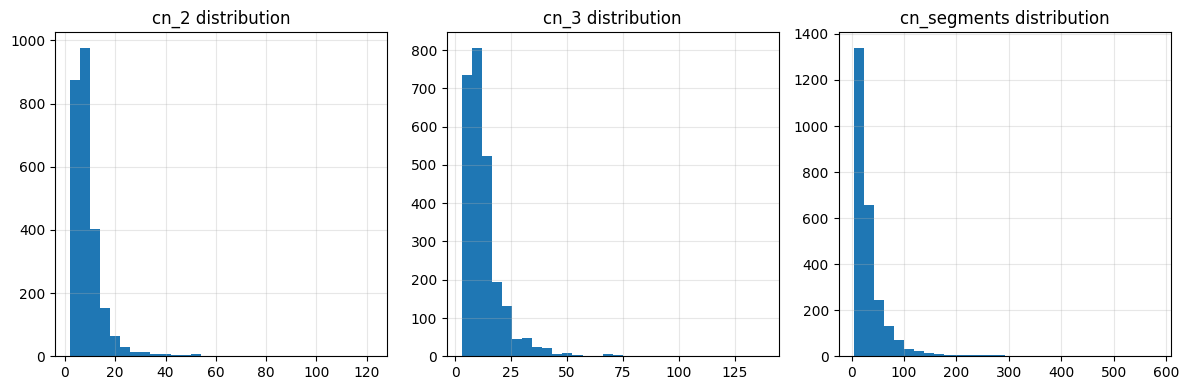

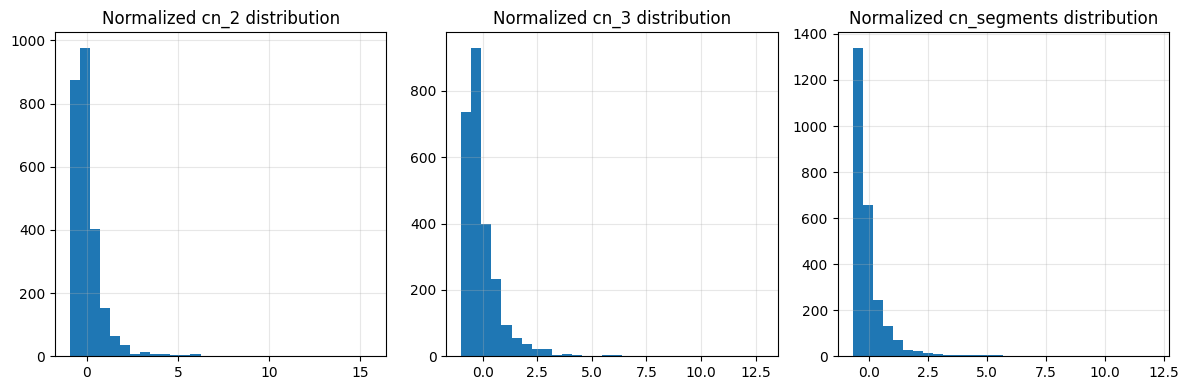

NameError: name 'train_image_features' is not defined

In [ ]:
# 可视化CNV特征分布
def visualize_features(df, feature_names):
    """可视化特征分布"""
    plt.figure(figsize=(12, 4))
    for i, name in enumerate(feature_names):
        plt.subplot(1, 3, i+1)
        plt.hist(df[name], bins=30)
        plt.title(f'{name} distribution')
        plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# 显示原始特征分布 [train_df]
features_names = ['cn_2', 'cn_3', 'cn_segments']
visualize_features(train_df, features_names)

# 标准化CNV特征
scaler = StandardScaler() # Z-score normalization
train_cnv_features_scaled = scaler.fit_transform(train_cnv_features)
test_cnv_features_scaled = scaler.transform(test_cnv_features)

# 可视化标准化后的特征 [train_cnv_features_scaled]
plt.figure(figsize=(12, 4))
for i, name in enumerate(features_names):
    plt.subplot(1, 3, i+1)
    plt.hist(train_cnv_features_scaled[:, i], bins=30)
    plt.title(f'Normalized {name} distribution')
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 合并特征
train_combined_features = np.hstack((train_image_features, train_cnv_features_scaled))
test_combined_features = np.hstack((test_image_features, test_cnv_features_scaled))

print(f"训练集合并特征形状: {train_combined_features.shape}")
print(f"测试集合并特征形状: {test_combined_features.shape}")

# 6. 保存处理后的特征

In [9]:
# 创建目录
os.makedirs('/Volumes/T7-shield/CS-Bachelor-Thesis/CNN_model/model_data/processed_data', exist_ok=True)

# 保存特征和标签
np.save('/Volumes/T7-shield/CS-Bachelor-Thesis/CNN_model/model_data/processed_data/train_combined_features.npy', train_combined_features)
np.save('/Volumes/T7-shield/CS-Bachelor-Thesis/CNN_model/model_data/processed_data/train_labels.npy', train_labels)
np.save('/Volumes/T7-shield/CS-Bachelor-Thesis/CNN_model/model_data/processed_data/test_combined_features.npy', test_combined_features)
np.save('/Volumes/T7-shield/CS-Bachelor-Thesis/CNN_model/model_data/processed_data/test_labels.npy', test_labels)

# 保存数据处理器
joblib.dump(scaler, '/Volumes/T7-shield/CS-Bachelor-Thesis/CNN_model/model_data/processed_data/cnv_scaler.pkl')

# 保存特征维度信息
np.save('/Volumes/T7-shield/CS-Bachelor-Thesis/CNN_model/model_data/processed_data/feature_dimensions.npy', 
       np.array([train_image_features.shape[1], train_cnv_features_scaled.shape[1]]))

print("所有数据处理完成并保存")


所有数据处理完成并保存


## 导入保存的特征向量

In [2]:
# 加载特征和标签
train_combined_features = np.load('/Volumes/T7-shield/CS-Bachelor-Thesis/CNN_model/model_data/processed_data/train_combined_features.npy')
train_labels = np.load('/Volumes/T7-shield/CS-Bachelor-Thesis/CNN_model/model_data/processed_data/train_labels.npy')
test_combined_features = np.load('/Volumes/T7-shield/CS-Bachelor-Thesis/CNN_model/model_data/processed_data/test_combined_features.npy')
test_labels = np.load('/Volumes/T7-shield/CS-Bachelor-Thesis/CNN_model/model_data/processed_data/test_labels.npy')

# 加载数据处理器
scaler = joblib.load('/Volumes/T7-shield/CS-Bachelor-Thesis/CNN_model/model_data/processed_data/cnv_scaler.pkl')

# 加载特征维度信息
feature_dimensions = np.load('/Volumes/T7-shield/CS-Bachelor-Thesis/CNN_model/model_data/processed_data/feature_dimensions.npy')

print("所有数据已成功加载")

所有数据已成功加载


# 7. 10折交叉验证训练
最佳参数: {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}  
交叉验证AUC: 0.9791

In [ ]:
def train_with_cross_validation(X, y, n_splits=10, random_state=42):
    """使用交叉验证训练模型"""
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    # 定义超参数网格
    param_grids = [
        # l1正则化 (需要用liblinear或saga求解器)
        {
            'penalty': ['l1'],
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'solver': ['liblinear', 'saga'],
            'class_weight': [None, 'balanced']
        },
        # l2正则化 (可以用多种求解器)
        {
            'penalty': ['l2'],
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'solver': ['liblinear', 'saga', 'lbfgs'],
            'class_weight': [None, 'balanced']
        },
        # elasticnet正则化 (只能用saga求解器，需要指定l1_ratio)
        {
            'penalty': ['elasticnet'],
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'solver': ['saga'],
            'l1_ratio': [0.2, 0.5, 0.8],
            'class_weight': [None, 'balanced']
        },
        # 无正则化 (不能用liblinear求解器)
        {
            'penalty': [None],
            'solver': ['newton-cg', 'lbfgs', 'saga'],
            'class_weight': [None, 'balanced']
        }
    ]
        
    # 创建网格搜索
    grid_search = GridSearchCV(
        LogisticRegression(max_iter=10000), 
        param_grids, 
        cv=cv, 
        scoring='roc_auc',
        n_jobs=-1
    )
        
    # 训练模型
    print("开始网格搜索...")
    grid_search.fit(X, y)
    
    # 获取最佳模型
    best_model = grid_search.best_estimator_
    print(f"最佳参数: {grid_search.best_params_}")
    print(f"交叉验证AUC: {grid_search.best_score_:.4f}")
    
    return best_model, grid_search, cv

# 执行交叉验证训练
best_model, grid_search, cv = train_with_cross_validation(train_combined_features, train_labels)


开始网格搜索...
最佳参数: {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}
交叉验证AUC: 0.9791


# 8. ROC曲线绘制

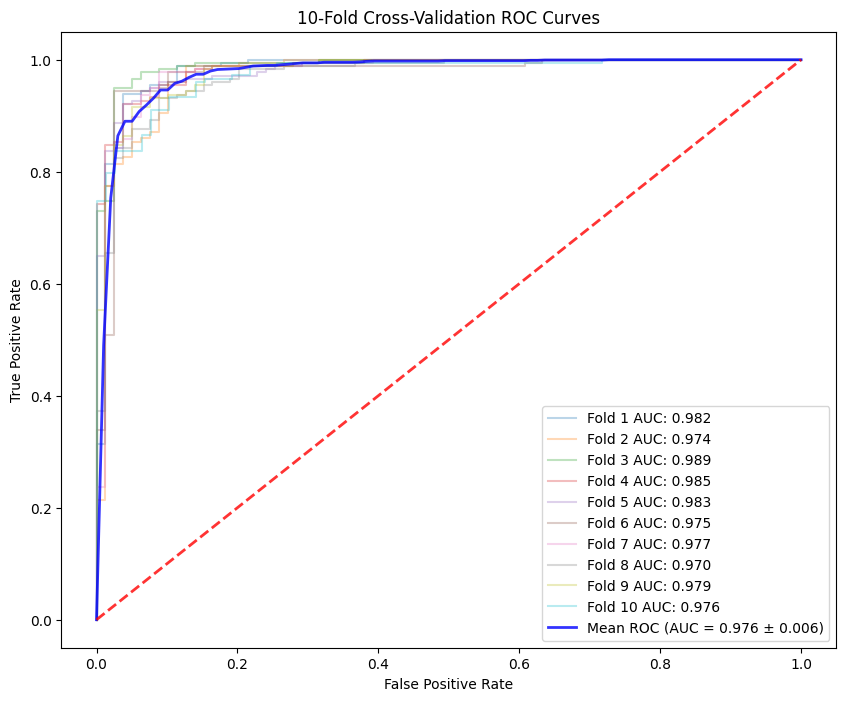

In [4]:
def plot_cv_roc_curves(X, y, cv, best_params, output_path=None):
    """绘制交叉验证ROC曲线"""
    plt.figure(figsize=(10, 8))
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_fold_train, X_fold_test = X[train_idx], X[test_idx]
        y_fold_train, y_fold_test = y[train_idx], y[test_idx]
        
        model = LogisticRegression(**best_params, max_iter=10000)
        model.fit(X_fold_train, y_fold_train)
        
        y_fold_prob = model.predict_proba(X_fold_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_fold_test, y_fold_prob)
        
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        
        fold_auc = auc(fpr, tpr)
        aucs.append(fold_auc)
        plt.plot(fpr, tpr, alpha=0.3, label=f'Fold {i+1} AUC: {fold_auc:.3f}')
    
    # 平均ROC曲线
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b', 
             label=f'Mean ROC (AUC = {mean_auc:.3f} ± {std_auc:.3f})',
             lw=2, alpha=0.8)
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('10-Fold Cross-Validation ROC Curves')
    plt.legend(loc="lower right")
    
    if output_path:
        plt.savefig(output_path)
    
    plt.show()
    
    return mean_auc, std_auc

# 绘制交叉验证ROC曲线
cv_output_path = '/Volumes/T7-shield/CS-Bachelor-Thesis/CNN_model/model_data/cv_roc_curve.png'
mean_auc, std_auc = plot_cv_roc_curves(
    train_combined_features, 
    train_labels, 
    cv, 
    grid_search.best_params_,
    cv_output_path
)


# 9. 特征重要性分析

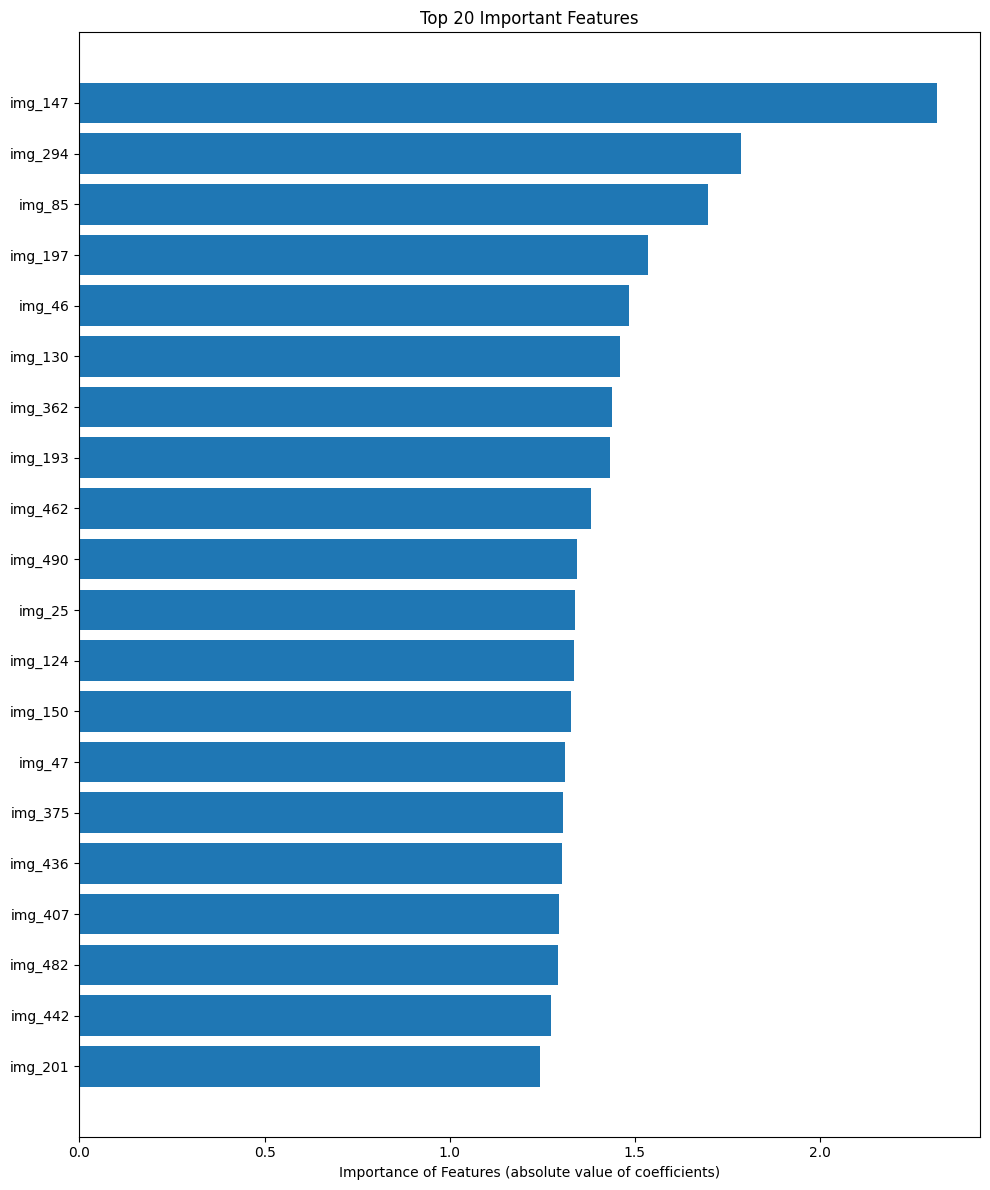

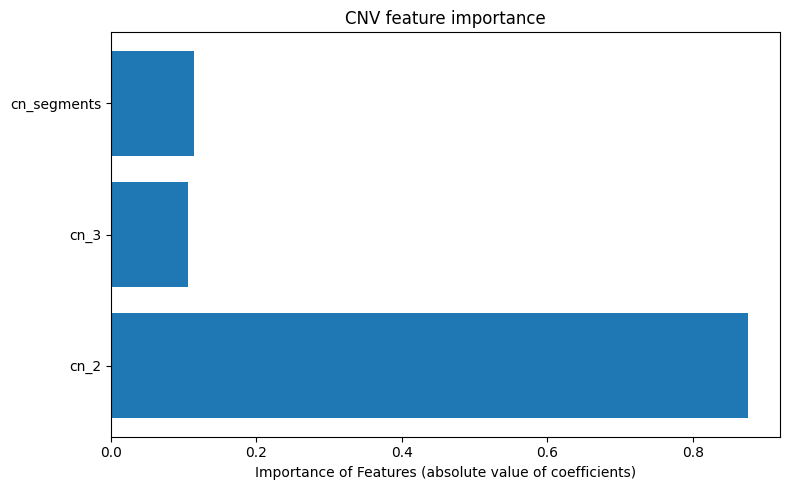

In [8]:
def analyze_feature_importance(model, X_train, output_path=None):
    """分析特征重要性"""
    if hasattr(model, 'coef_'):
        # 加载特征维度
        dimensions = np.load('/Volumes/T7-shield/CS-Bachelor-Thesis/CNN_model/model_data/processed_data/feature_dimensions.npy')
        img_features_dim = dimensions[0]
        cnv_features_dim = dimensions[1]
        
        # 创建特征名称
        feature_names = [f'img_{i}' for i in range(img_features_dim)]
        feature_names.extend(['cn_2', 'cn_3', 'cn_segments'])
        
        # 获取系数
        coefs = model.coef_[0]
        
        # 计算特征重要性
        importance = np.abs(coefs)
        
        # 找出最重要的特征（前20个）
        top_indices = np.argsort(importance)[-20:]
        
        plt.figure(figsize=(10, 12))
        plt.barh([feature_names[i] for i in top_indices], importance[top_indices])
        plt.xlabel('Importance of Features (absolute value of coefficients)')
        plt.title('Top 20 Important Features')
        plt.tight_layout()
        
        if output_path:
            plt.savefig(output_path)
        
        plt.show()
        
        # 单独查看CNV特征的重要性
        cnv_indices = np.arange(img_features_dim, img_features_dim + cnv_features_dim)
        cnv_names = ['cn_2', 'cn_3', 'cn_segments']
        
        plt.figure(figsize=(8, 5))
        plt.barh(cnv_names, np.abs(coefs[cnv_indices]))
        plt.xlabel('Importance of Features (absolute value of coefficients)')
        plt.title('CNV feature importance')
        plt.tight_layout()
        
        if output_path:
            plt.savefig(output_path.replace('.png', '_cnv.png'))
        
        plt.show()

# 分析特征重要性
importance_output_path = '/Volumes/T7-shield/CS-Bachelor-Thesis/CNN_model/model_data/feature_importance.png'
analyze_feature_importance(best_model, train_combined_features, importance_output_path)


# 10.  保存最佳模型

In [5]:
# 保存模型
model_path = '/Volumes/T7-shield/CS-Bachelor-Thesis/CNN_model/model_data/best_model.pkl'
joblib.dump(best_model, model_path)
print(f"最佳模型已保存到 {model_path}")

最佳模型已保存到 /Volumes/T7-shield/CS-Bachelor-Thesis/CNN_model/model_data/best_model.pkl


# 11. 独立测试集评估

测试集准确率: 0.9472
分类报告:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90        72
           1       0.98      0.95      0.96       212

    accuracy                           0.95       284
   macro avg       0.92      0.94      0.93       284
weighted avg       0.95      0.95      0.95       284



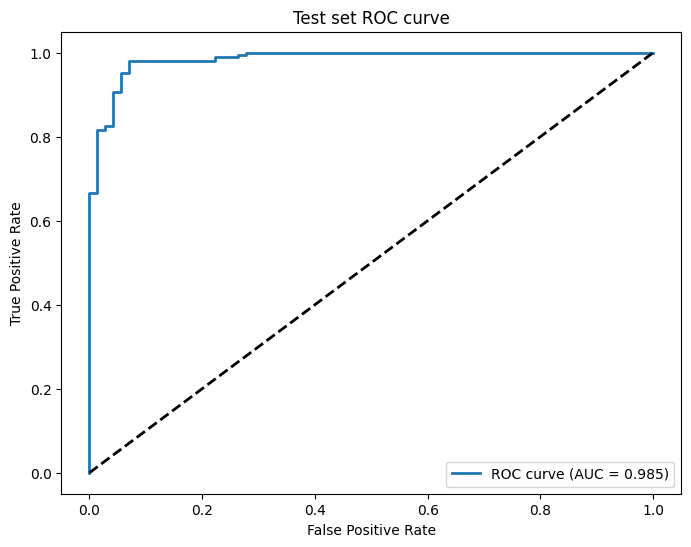

模型训练和评估完成!


In [9]:
def evaluate_on_test_set(model, X_test, y_test, output_path=None):
    """在独立测试集上评估模型"""
    # 预测
    test_pred = model.predict(X_test)
    test_prob = model.predict_proba(X_test)[:, 1]
    
    # 准确率
    test_accuracy = accuracy_score(y_test, test_pred)
    print(f"测试集准确率: {test_accuracy:.4f}")
    
    # 分类报告
    print("分类报告:")
    print(classification_report(y_test, test_pred))
    
    # ROC曲线和AUC
    fpr, tpr, _ = roc_curve(y_test, test_prob)
    test_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {test_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Test set ROC curve')
    plt.legend(loc="lower right")
    
    if output_path:
        plt.savefig(output_path)
    
    plt.show()
    
    return test_accuracy, test_auc

# 评估测试集
test_output_path = '/Volumes/T7-shield/CS-Bachelor-Thesis/CNN_model/model_data/test_roc_curve.png'
test_accuracy, test_auc = evaluate_on_test_set(best_model, test_combined_features, test_labels, test_output_path)

print("模型训练和评估完成!")


# 12. 与ShatterSeek进行比较


查看ShatterSeek在独立测试集的表现，通过 abnormal_calls_from_PCAWG的数据中的 comment 列反推ShatterSeek的结果

In [12]:
import pandas as pd
import re

# 文件路径
abnormal_file = "/Volumes/T7-shield/CS-Bachelor-Thesis/CNN_model/PCAWG-related/abnormal_calls_from_PCAWG.tsv"
test_data_file = "/Volumes/T7-shield/CS-Bachelor-Thesis/CNN_model/model_data/test_data.tsv"

# 读取数据
print("读取abnormal数据...")
abnormal_df = pd.read_csv(abnormal_file, sep='\t')
print("读取test_data数据...")
test_df = pd.read_csv(test_data_file, sep='\t')

# 添加新列用于记录ShatterSeek结果
test_df['shatterseek_result'] = None
# 添加一个临时列记录是否真正匹配到了abnormal记录
test_df['_matched_abnormal'] = False

# 确保数据类型正确
abnormal_df['Chr'] = abnormal_df['Chr'].astype(str)
abnormal_df['Start'] = pd.to_numeric(abnormal_df['Start'], errors='coerce')
abnormal_df['End'] = pd.to_numeric(abnormal_df['End'], errors='coerce')

# 处理test_df中的染色体位置信息
for idx, row in test_df.iterrows():
    if idx % 100 == 0:
        print(f"处理测试数据行 {idx}/{len(test_df)}...")
    
    # 查找匹配的abnormal记录
    matches = abnormal_df[
        (abnormal_df['donor_idx'] == row['sample_name']) &
        (abnormal_df['Chr'] == str(row['Chr'])) &
        (abnormal_df['Start'] == row['Start']) &
        (abnormal_df['End'] == row['End'])
    ]
    
    if len(matches) > 1:
        print(f"警告: 行 {idx} 匹配到多个abnormal记录 ({len(matches)}条)")
        test_df.at[idx, '_matched_abnormal'] = True
    elif len(matches) == 1:
        test_df.at[idx, '_matched_abnormal'] = True
        comment = matches.iloc[0]['comment']
        
        # 根据comment设置shatterseek结果
        if "False positive; manually removed" in comment:
            test_df.at[idx, 'shatterseek_result'] = 1
        elif "False negative; manually included" in comment:
            test_df.at[idx, 'shatterseek_result'] = 0
        else:
            # 如果注释不符合预期格式，打印警告
            print(f"警告: 未知的comment格式: {comment}")

# 统计真正匹配到的abnormal记录数
true_match_count = test_df['_matched_abnormal'].sum()
print(f"匹配到abnormal记录的数量: {true_match_count}")

# 对于未匹配的数据，使用label列的值
test_df.loc[test_df['shatterseek_result'].isna(), 'shatterseek_result'] = test_df.loc[test_df['shatterseek_result'].isna(), 'label']

# 报告结果
total_count = len(test_df)
non_na_count = sum(~test_df['shatterseek_result'].isna())
print(f"总记录数: {total_count}")
print(f"非空shatterseek_result记录数: {non_na_count}")
print(f"其中从abnormal匹配到的记录数: {true_match_count}")
print(f"从label填充的记录数: {non_na_count - true_match_count}")
print(f"ShatterSeek结果统计: ")
print(test_df['shatterseek_result'].value_counts())

# 删除临时列
test_df.drop('_matched_abnormal', axis=1, inplace=True)


读取abnormal数据...
读取test_data数据...
处理测试数据行 0/284...
处理测试数据行 100/284...
处理测试数据行 200/284...
匹配到abnormal记录的数量: 12
总记录数: 284
非空shatterseek_result记录数: 284
其中从abnormal匹配到的记录数: 12
从label填充的记录数: 272
ShatterSeek结果统计: 
shatterseek_result
1    224
0     60
Name: count, dtype: int64


比较我们的工具 ChromShatter 和 ShatterSeek 在独立测试集上的差异

加载处理后的特征...
加载模型...
进行模型预测...
读取ShatterSeek结果...
ChromShatter性能：
精确率: 0.9758
召回率: 0.9528
F1分数: 0.9642

ShatterSeek性能：
精确率: 0.9464
召回率: 1.0000
F1分数: 0.9725


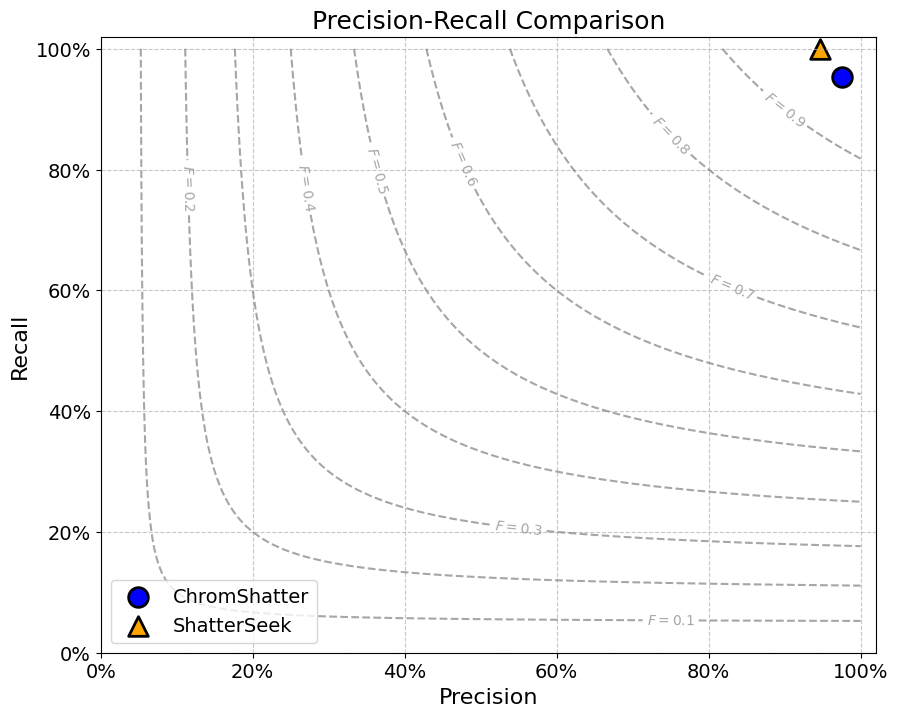

图表已保存到: /Volumes/T7-shield/CS-Bachelor-Thesis/CNN_model/model_data/precision_recall_comparison.png


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import pickle
import os
import joblib

# 文件路径
base_dir = "/Volumes/T7-shield/CS-Bachelor-Thesis/CNN_model"
model_path = os.path.join(base_dir, "model_data/best_model.pkl")
features_path = os.path.join(base_dir, "model_data/processed_data/test_combined_features.npy")
labels_path = os.path.join(base_dir, "model_data/processed_data/test_labels.npy")
output_path = os.path.join(base_dir, "model_data/precision_recall_comparison.png")

# test_df 需要执行上一段代码获得

# 加载已保存的特征
print("加载处理后的特征...")
X_test = np.load(features_path)
y_true = np.load(labels_path)

print("加载模型...")
best_model = joblib.load(model_path)

print("进行模型预测...")
y_pred_chromshatter = best_model.predict(X_test)
y_prob_chromshatter = best_model.predict_proba(X_test)[:, 1]  # 获取正类的概率

# 获取ShatterSeek结果（从test_df的shatterseek_result列）
print("读取ShatterSeek结果...")
if 'shatterseek_result' not in test_df.columns:
    raise ValueError("测试数据中缺少shatterseek_result列，请先运行添加ShatterSeek结果的代码")

y_pred_shatterseek = test_df['shatterseek_result'].astype(int).values
y_true_shatterseek = test_df['label'].astype(int).values

# 检查数据是否只包含0和1
unique_pred = np.unique(y_pred_shatterseek)
unique_true = np.unique(y_true_shatterseek)

if not set(unique_pred).issubset({0, 1}):
    print(f"错误: shatterseek_result列包含非二元值: {unique_pred}")
    print("程序将退出。请确保数据只包含0和1")
    import sys
    sys.exit(1)

if not set(unique_true).issubset({0, 1}):
    print(f"错误: label列包含非二元值: {unique_true}")
    print("程序将退出。请确保数据只包含0和1")
    import sys
    sys.exit(1)

if len(y_true_shatterseek) != len(y_pred_shatterseek):
    raise ValueError(f"ShatterSeek结果长度 ({len(y_pred_shatterseek)}) 与真实标签长度 ({len(y_true_shatterseek)}) 不匹配")

# 计算各种指标
# ChromShatter指标
precision_chromshatter = precision_score(y_true, y_pred_chromshatter)
recall_chromshatter = recall_score(y_true, y_pred_chromshatter)
f1_chromshatter = f1_score(y_true, y_pred_chromshatter)

# ShatterSeek指标
precision_shatterseek = precision_score(y_true_shatterseek, y_pred_shatterseek)
recall_shatterseek = recall_score(y_true_shatterseek, y_pred_shatterseek)
f1_shatterseek = f1_score(y_true_shatterseek, y_pred_shatterseek)

print("ChromShatter性能：")
print(f"精确率: {precision_chromshatter:.4f}")
print(f"召回率: {recall_chromshatter:.4f}")
print(f"F1分数: {f1_chromshatter:.4f}")

print("\nShatterSeek性能：")
print(f"精确率: {precision_shatterseek:.4f}")
print(f"召回率: {recall_shatterseek:.4f}")
print(f"F1分数: {f1_shatterseek:.4f}")

# 绘制Precision-Recall图
plt.figure(figsize=(10, 8))

# 绘制F1等值线
def plot_f1_contours():
    # 创建精确率和召回率的网格
    precision_range = np.linspace(0.01, 1, 100)
    recall_range = np.linspace(0.01, 1, 100)
    P, R = np.meshgrid(precision_range, recall_range)
    
    # 计算F1值
    F1 = 2 * P * R / (P + R + 1e-10)
    
    # 绘制F1等值线
    levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    contours = plt.contour(P, R, F1, levels=levels, colors='gray', linestyles='dashed', alpha=0.7)
    
    # 添加等值线标签
    plt.clabel(contours, inline=True, fontsize=10, fmt='$F = %.1f$')

# 绘制F1等值线
plot_f1_contours()

# 绘制模型点
# ChromShatter用圆圈表示
plt.scatter(precision_chromshatter, recall_chromshatter, marker='o', s=200, 
           color='blue', label='ChromShatter', edgecolors='black', linewidth=2)

# ShatterSeek用三角形表示
plt.scatter(precision_shatterseek, recall_shatterseek, marker='^', s=200, 
           color='orange', label='ShatterSeek', edgecolors='black', linewidth=2)

# 设置图表属性
plt.xlabel('Precision', fontsize=16)
plt.ylabel('Recall', fontsize=16)
plt.title('Precision-Recall Comparison', fontsize=18)
plt.xlim(0, 1.02)
plt.ylim(0, 1.02)
plt.xticks(np.arange(0, 1.1, 0.2), [f"{int(x*100)}%" for x in np.arange(0, 1.1, 0.2)], fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.2), [f"{int(x*100)}%" for x in np.arange(0, 1.1, 0.2)], fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=14, loc='lower left')

# 保存图表
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"图表已保存到: {output_path}")
